In [222]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

In [223]:
file_path = "CT_scan.npy"
images = np.load(file_path)

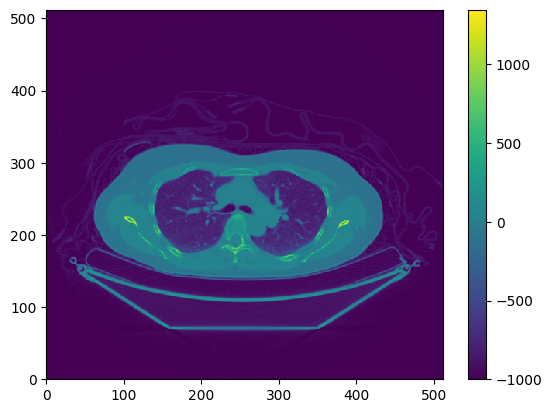

In [224]:
plt.pcolormesh(images[180])
plt.colorbar()

In [225]:
images.shape # -> 263 images (correspondant au nombre de coupes) de résolution 512x512

(263, 512, 512)

In [226]:
images[120][15,15] # -> Intensité du pixel en position (15,15) de -1000, ce qui n'est pas le format habituel uint8 ou uint16 pour des images

np.int16(-1000)

Cela viens du fait que l'unité utilisé içi pour chaque pixel correspond au Hounsfield qui donne une information sur la densité du tissu par lequel le rayon de photon est passé. De cette manière les tissu de différent densité ont une intensité en pixel qui est très différente.
L'intensité est calculé de la manière suivante :
                      $HU(x,y)= 1000 * \frac{\mu(x,y)-\mu_{eau}}{\mu_{eau}-\mu_{air}}$ \
avec $\mu(x,y)$ correspondant au coefficient d'atténuation linéaire du tissu.

In [227]:
masks = images < -320

En appliquant un threshold correspondant à la valeur de HU pour l'air (-320) on peut alors une séparation des éléments très peu dense (ou avec beaucoup d'air comme les poumons) et les tissus denses.

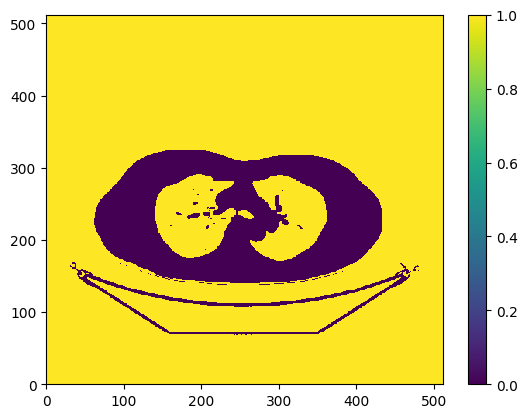

In [228]:
plt.pcolormesh(masks[180])
plt.colorbar()

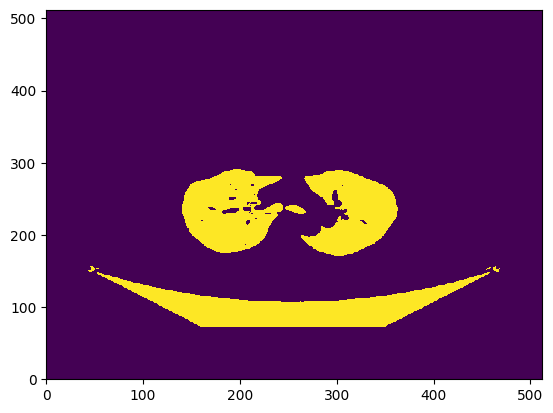

In [229]:
masks = np.vectorize(clear_border, signature='(n,m) -> (n,m)')(masks)
plt.pcolormesh(masks[180])

On a supprimé les bordure des éléments en utilisant "clear_border" de la bibliothéque skimage et la fonction "vectiorize" qui permet d'appliquer un traitement donné à un vecteur bien plus rapidement que si on le faisait avec une for loop par exemple

In [230]:
mask_labeled = np.vectorize(label, signature='(n,m) -> (n,m)')(masks)

In [231]:
def keep_top_3(slc):
    
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]

    new_slice = np.zeros_like(slc)
    for i in idxs[:3]:
        new_slice[tuple(rps[i].coords.T)] = i+1
    return new_slice
        

In [232]:
mask_labeled = np.vectorize(keep_top_3, signature= '(n,m) -> (n,m)')(mask_labeled)

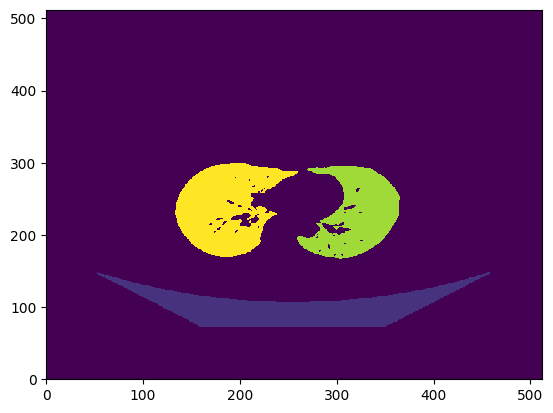

In [233]:
plt.pcolormesh(mask_labeled[170])

In [234]:
mask = mask_labeled > 0

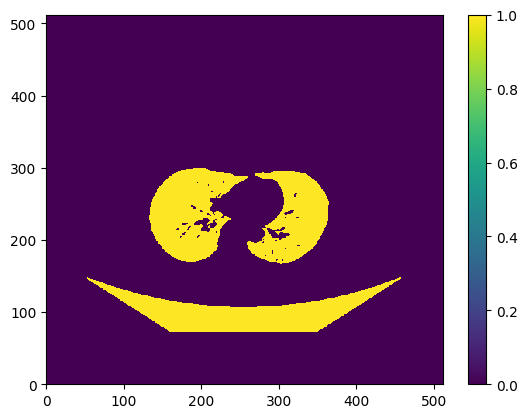

In [235]:
plt.pcolormesh(mask[170])
plt.colorbar()

In [236]:
mask = np.vectorize(ndi.binary_fill_holes, signature= '(n,m) -> (n,m)')(mask)

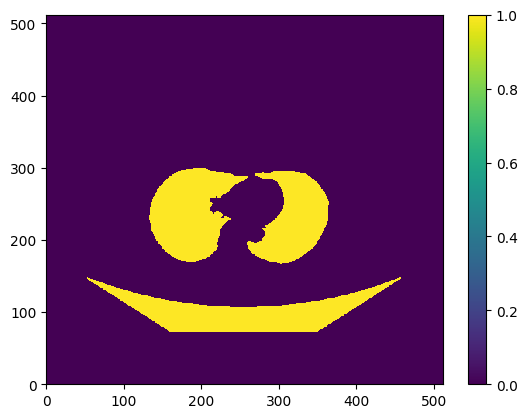

In [237]:
plt.pcolormesh(mask[170])
plt.colorbar()

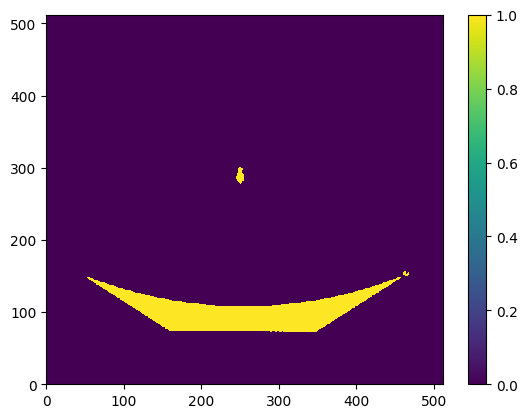

In [238]:
plt.pcolormesh(mask[-50])
plt.colorbar()

On remarque que pour certaine coupe la traché est aussi prise ne compte dans la segmentation du poumon.

In [239]:
slc = mask[-50]
slc_labeled = label(slc)
rps = regionprops(slc_labeled)
areas = [r.area for r in rps]
idxs = np.argsort(areas)
print(idxs) # -> L'air minimal correspondant à la traché (deuxième élément le plus petit sur la coupe)

[1 2 0]


In [240]:
prc_trache = (areas[2]/ slc.shape[0]**2)*100
print(prc_trache)

0.064849853515625


La part de l'air occupé par la traché sur l'image correspond à 0.065% de l'image compléte. Ainsi, pour segmenter les poumons sans prendre en compte la traché, on va enelever tous les éléments dont l'air occupé est inférieur à ce pourcentage.

In [241]:
def remove_trache(slc, c=0.0065):
    new_slc = slc.copy()

    labeled = label(new_slc, connectivity=1,background=0)
    rps = regionprops(labeled)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/512**2 < c)[0]

    
    for i in idxs :
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc
            
    

In [242]:
mask = np.vectorize(remove_trache, signature='(n,m) -> (n,m)')(mask)

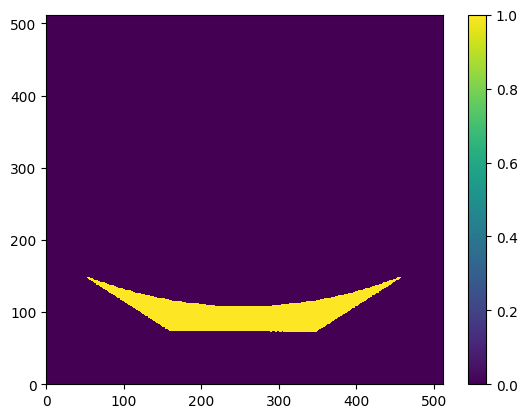

In [243]:
plt.pcolormesh(mask[-50])
plt.colorbar()

In [244]:
def delete_table(slc):
    new_slc = slc.copy()

    labels = label(new_slc, background=0)
    idxs = np.unique(labels)[1:]
    com = np.array([center_of_mass(labels == i)[0] for i in idxs ])
    for idx,c in zip(idxs, com):
        if c < 0.3*slc.shape[0]:
            new_slc[labels==idx] = 0
        if c > 0.6*slc.shape[0]:
            new_slc[labels==idx] = 0
    return new_slc

In [245]:
mask = np.vectorize(delete_table,signature= '(n,m) -> (n,m)')(mask)

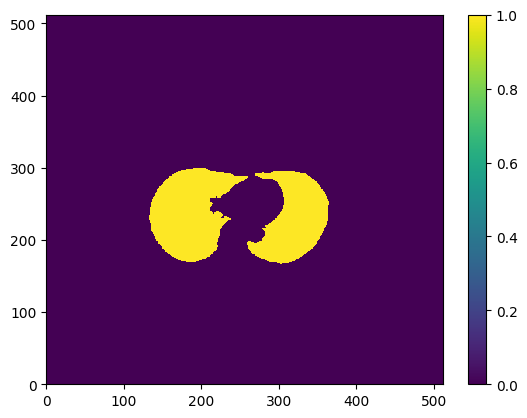

In [246]:
plt.pcolormesh(mask[170])
plt.colorbar()

In [247]:
mask = binary_dilation(mask,iterations=5)

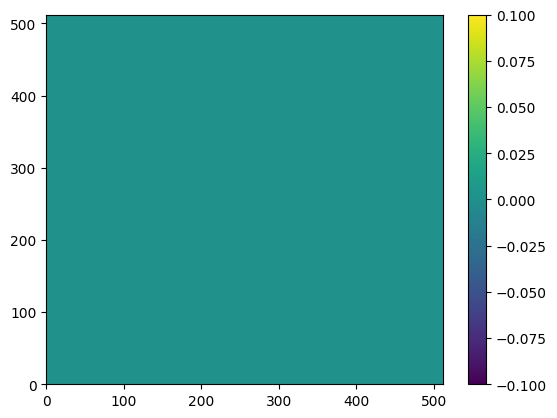

In [253]:
plt.pcolormesh(mask[220])
plt.colorbar()

In [249]:
im = zoom(1*(mask), (0.4,0.4,0.4))

In [250]:
z,y,x = [np.arange(i) for i in im.shape]
z *= 4

In [251]:
X, Y, Z = np.meshgrid(x,y,z, indexing='ij')

In [252]:
fig = go.Figure(data=go.Volume(
    x = X.flatten(),
    y = Y.flatten(),
    z = Z.flatten(),
    value =np.transpose(im, (1,2,0)).flatten(),
    isomin = 0.1,
    opacity = 0.1,
    surface_count= 17     
))

fig.write_html("test.html")